### Q1. Function Approximation with RBFN (10 Marks)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from scipy.io import loadmat
from sklearn.metrics import accuracy_score

In [2]:
# define the function
def func(x):
    return np.sin(math.pi * x) * 1.2 - np.cos(2.4 * math.pi * x)
# define the corrupted function
def func_co(x):
    return np.sin(math.pi * x) * 1.2 - np.cos(2.4 * math.pi * x) + 0.3 * np.random.normal(0,1,x.shape)

In [3]:
# generate training and test dataset

In [4]:
X_train = np.arange(-1, 1+0.05, 0.05)
X_test = np.arange(-1, 1+0.01, 0.01)

In [5]:
y_train = func_co(X_train)
y_test = func(X_test)

Text(0.5, 1.0, 'y(i)=2sin(pi x(i)) - cos(2.4pi x(i)) + 0.3n(i)')

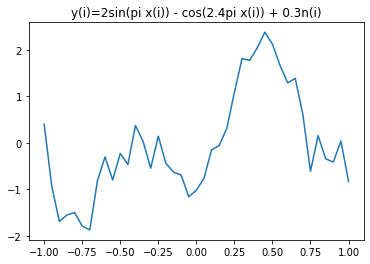

In [6]:
plt.plot(X_train, y_train)
plt.title('y(i)=2sin(pi x(i)) - cos(2.4pi x(i)) + 0.3n(i)')

Text(0.5, 1.0, 'y=2sin(pi x) - cos(2.4pi x)')

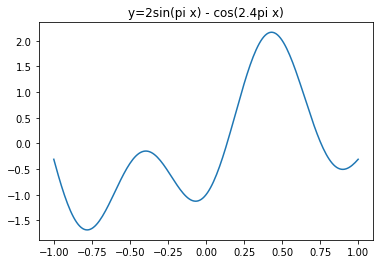

In [7]:
plt.plot(X_test, y_test)
plt.title('y=2sin(pi x) - cos(2.4pi x)')

In [103]:
class RBF:
    def __init__(self, sigma=1.0, centre_selection='random', hidden_neurons=0, reg = 0):
        self.sigma = sigma
        self.centers = None
        self.weights = None
        self.centre_selection = centre_selection
        self.hidden_neurons = hidden_neurons
        self.reg = reg

    def _kernel_function(self, center, data_point):
        return np.sum(np.exp(- (center-data_point)**2 / (2 * self.sigma**2)))

    def _calculate_interpolation_matrix(self, x):
        matrix = np.zeros((len(x), self.hidden_neurons))
        for data_point_arg, data_point in enumerate(x):
            for center_arg, center in enumerate(self.centers):
                matrix[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return matrix
    
    def _getMaxDist(self,x, random_args):
        max_dist = 0
        # can be optimised to omit duplicated computation
        for i in random_args:
            for j in random_args:
                dist = np.linalg.norm(x[i]-[j])
                if dist > max_dist:
                    max_dist = dist
        return max_dist

    def _select_centers(self, x):
        if self.centre_selection == 'exact_interpolation':
            # simply randomly select centres
            self.hidden_neurons = len(x)
            random_args = np.arange(0, len(x))
        elif self.centre_selection == 'fixed_centers_selected_at_random':
            # randomly select M points
            random_args = np.random.choice(len(x), self.hidden_neurons)
            centers = x[random_args]
            if len(centers.shape) == 1:
                centers = np.expand_dims(centers, axis=1)
            max_dist = np.max(pdist(centers, metric="euclidean"))
            self.sigma = max_dist / np.sqrt(2 * self.hidden_neurons)
        centers = x[random_args]
        return centers

    def fit(self, x, y):
        self.centers = self._select_centers(x)
        matrix = self._calculate_interpolation_matrix(x)
        inv_matrix = np.linalg.pinv(matrix)
        trans_matrix = np.transpose(matrix)
        if self.reg != 0:
            inv = np.linalg.pinv( np.dot(trans_matrix, matrix) + self.reg * np.identity(self.hidden_neurons))
            m = np.dot(inv, trans_matrix)
            m = np.dot(m, y)
            self.weights = m
        else:
            self.weights = np.dot(inv_matrix, y)

    def predict(self, x):
        matrix = self._calculate_interpolation_matrix(x)
        predictions = np.dot(matrix, self.weights)
        return predictions
    
    def get_mae(self, x, y):
        matrix = self._calculate_interpolation_matrix(x)
        predictions = np.dot(matrix, self.weights)
        error = np.mean(np.abs(y-predictions))
        return error

### 1 a) exact_interpolation

test mse:  0.26430555466386674


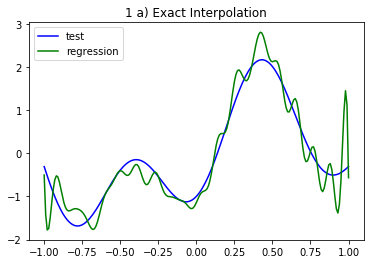

In [104]:
model = RBF(sigma=0.1, centre_selection = 'exact_interpolation')

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
mae_test = model.get_mae(X_test, y_test)
print('test mse: ', mae_test)

plt.plot(X_test, y_test, 'b-', label='test')
plt.plot(X_test, y_test_pred, 'g-', label='regression')
plt.legend(loc='upper left')
plt.title('1 a) Exact Interpolation')

plt.show()

In [106]:
# get average MAE for 100 iterations

iteration = 100
mae_toal = 0
for i in range(iteration):
    y_train = func_co(X_train)
    model = RBF(sigma=0.1, centre_selection = 'exact_interpolation')

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    mae_toal += model.get_mae(X_test, y_test)
print('average MAE: ', mae_toal/iteration)

average MAE:  0.2822199237670857


In [12]:
### 1 b) fixed_centers_selected_at_random at 15 hidden neurons

mae_test: 0.1668383874711065


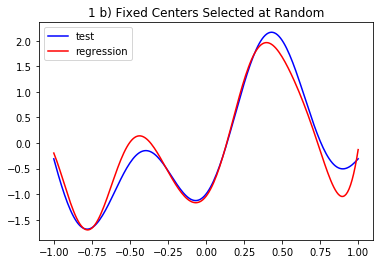

In [108]:
model = RBF(centre_selection = 'fixed_centers_selected_at_random', hidden_neurons=15)

model.fit(X_train, y_train)
predicted_y = model.predict(X_test)
mae_test = model.get_mae(X_test, y_test)
print('mae_test:', mae_test)
plt.plot(X_test, y_test, 'b-', label='test')
plt.plot(X_test, predicted_y, 'r-', label='regression')
plt.legend(loc='upper left')
plt.title('1 b) Fixed Centers Selected at Random')
plt.show()

In [109]:
iteration = 100
mae_toal = 0
for i in range(iteration):
    y_train = func_co(X_train)
    model = RBF(centre_selection = 'fixed_centers_selected_at_random', hidden_neurons=15)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    mae_toal += model.get_mae(X_test, y_test)
print('average MAE: ', mae_toal/iteration)

average MAE:  0.12714447662727169


In [14]:
model = RBF(sigma=0.1, centre_selection = 'exact_interpolation', reg=0.1)

model.fit(X_train, y_train)
predicted_y = model.predict(X_test)

plt.plot(X_test, y_test, 'b-', label='test')
plt.plot(X_test, predicted_y, 'r-', label='regression')
plt.legend(loc='upper left')
plt.title('1 c) Exact Interpolation with Reg=0.1')
plt.show()

In [116]:
regs = np.arange(0.01, 1.00, 0.01)
mae_lst = []
for reg in regs:
    iteration = 100
    mae_toal = 0
    for i in range(iteration):
        y_train = func_co(X_train)
        model = RBF(sigma=0.1, centre_selection = 'exact_interpolation', reg=reg)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        mae_toal += model.get_mae(X_test, y_test)
    mae_lst.append(mae_toal/iteration)
    print('reg: {}, average MAE: {}'.format(reg, mae_toal/iteration))

reg: 0.01, average MAE: 0.15029114381990027
reg: 0.02, average MAE: 0.1530452738795069
reg: 0.03, average MAE: 0.1500373231755094
reg: 0.04, average MAE: 0.14687551864242152
reg: 0.05, average MAE: 0.14759059387095513
reg: 0.060000000000000005, average MAE: 0.1433832153523471
reg: 0.06999999999999999, average MAE: 0.1428166666245915
reg: 0.08, average MAE: 0.14207404336612572
reg: 0.09, average MAE: 0.14123654248956888
reg: 0.09999999999999999, average MAE: 0.13643993759072195
reg: 0.11, average MAE: 0.1376500970102095
reg: 0.12, average MAE: 0.13666609128302157
reg: 0.13, average MAE: 0.13307109371119566
reg: 0.14, average MAE: 0.13302434984455386
reg: 0.15000000000000002, average MAE: 0.135466747613431
reg: 0.16, average MAE: 0.13554140436450487
reg: 0.17, average MAE: 0.13589908739373935
reg: 0.18000000000000002, average MAE: 0.13950837064055294
reg: 0.19, average MAE: 0.13593240871534726
reg: 0.2, average MAE: 0.13013992228304908
reg: 0.21000000000000002, average MAE: 0.13062164981

Text(0.5, 1.0, 'MAE vs Regularization')

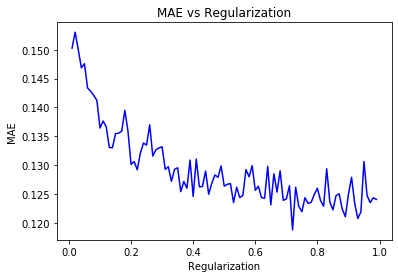

In [117]:
plt.plot(regs, mae_lst, 'b')
plt.xlabel('Regularization')
plt.ylabel('MAE')
plt.title('MAE vs Regularization')

### Q2. Handwritten Digits Classification using RBFN (20 Marks)

In [118]:
class RBF_classification:
    def __init__(self, sigma=1.0, centre_selection='random', hidden_neurons=0, reg = 0, n_clusters=2):
        self.sigma = sigma
        self.centers = None
        self.weights = None
        self.centre_selection = centre_selection
        self.hidden_neurons = hidden_neurons
        self.reg = reg
        self.n_clusters = n_clusters

    def _kernel_function(self, center, data_point):
        return np.sum(np.exp(- (center-data_point)**2 / (2 * self.sigma**2)))

    def _calculate_interpolation_matrix(self, x):
        matrix = np.zeros((len(x), self.hidden_neurons))
        for data_point_arg, data_point in enumerate(x):
            for center_arg, center in enumerate(self.centers):
                matrix[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return matrix
    
    def _getMaxDist(self,x, random_args):
        max_dist = 0
        # can be optimised to omit duplicated computation
        for i in random_args:
            for j in random_args:
                dist = np.linalg.norm(x[i]-[j])
                if dist > max_dist:
                    max_dist = dist
        return max_dist

    def _select_centers(self, x):
        if self.centre_selection == 'exact_interpolation':
            # simply randomly select centres
            self.hidden_neurons = len(x)
            random_args = np.arange(0, len(x))
            centers = x[random_args]
        elif self.centre_selection == 'fixed_centers_selected_at_random':
            # randomly select M points
            random_args = np.random.choice(len(x), self.hidden_neurons)
            centers = x[random_args]
            if len(centers.shape) == 1:
                centers = np.expand_dims(centers, axis=1)
            max_dist = np.max(pdist(centers, metric="euclidean"))
            self.sigma = max_dist / np.sqrt(2 * self.hidden_neurons)
            centers = x[random_args]
        elif self.centre_selection == 'kmeans':
            kmean = KMeans(n_clusters=self.n_clusters)
            kmean.fit(x)
            centers = kmean.cluster_centers_
        return centers

    def fit(self, x, y):
        self.centers = self._select_centers(x)
        matrix = self._calculate_interpolation_matrix(x)
        inv_matrix = np.linalg.pinv(matrix)
        trans_matrix = np.transpose(matrix)
        if self.reg != 0:
            inv = np.linalg.pinv( np.dot(trans_matrix, matrix) + self.reg * np.identity(self.hidden_neurons))
            m = np.dot(inv, trans_matrix)
            m = np.dot(m, y)
            self.weights = m
        else:
            self.weights = np.dot(inv_matrix, y)

    def predict(self, x):
        matrix = self._calculate_interpolation_matrix(x)
        y_pred = np.dot(matrix, self.weights)
        return y_pred
    
    def evaluate(self, y_pred_train, y_train, y_pred_test, y_test):
        # predict with different threshold as page 2
        n = 1000
        acc_train = np.zeros(n)
        acc_test = np.zeros(n)
        th = np.zeros(n)
        
        for i in range(n):
          t = (np.max(y_pred_train)-np.min(y_pred_train)) * ((i+1)-1)/1000 + np.min(y_pred_train)
          th[i] = t
          acc_train[i] = np.sum((y_pred_train>=t)==y_train)/len(y_pred_train)
          acc_test[i] = np.sum((y_pred_test>=t)==y_test)/len(y_pred_test)
        return th, acc_train, acc_test

    def get_binary_label(self, y_predicted, threshold):
        y_predicted[y_predicted > 0.5] = 1
        y_predicted[y_predicted <= 0.5] = 0
        return y_predicted
        

In [119]:
data = loadmat("MNIST_database.mat")
index_train = np.squeeze((data["train_classlabel"] == 4) | (data["train_classlabel"] == 8))
index_test = np.squeeze((data["test_classlabel"] == 4) | (data["test_classlabel"] == 8))
X_train = data["train_data"][:,index_train].transpose()
y_train = np.squeeze(data["train_classlabel"][:,index_train])
y_train = (y_train == 4).astype(int) # convert to 1, 0
X_test = data["test_data"][:,index_test].transpose()
y_test = np.squeeze(data["test_classlabel"][:,index_test])
y_test = (y_test == 4).astype(int) # convert to 1,0

### 2. a) Use Exact Interpolation Method

In [130]:
model = RBF_classification(sigma=100, centre_selection = 'exact_interpolation')

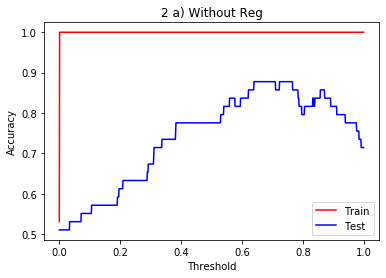

In [131]:
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
th, acc_train, acc_test = model.evaluate(y_pred_train, y_train, y_pred_test, y_test)
plt.plot(th, acc_train, 'r', label="Train")
plt.plot(th, acc_test,'b', label="Test")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.title('2 a) Without Reg')
plt.show()

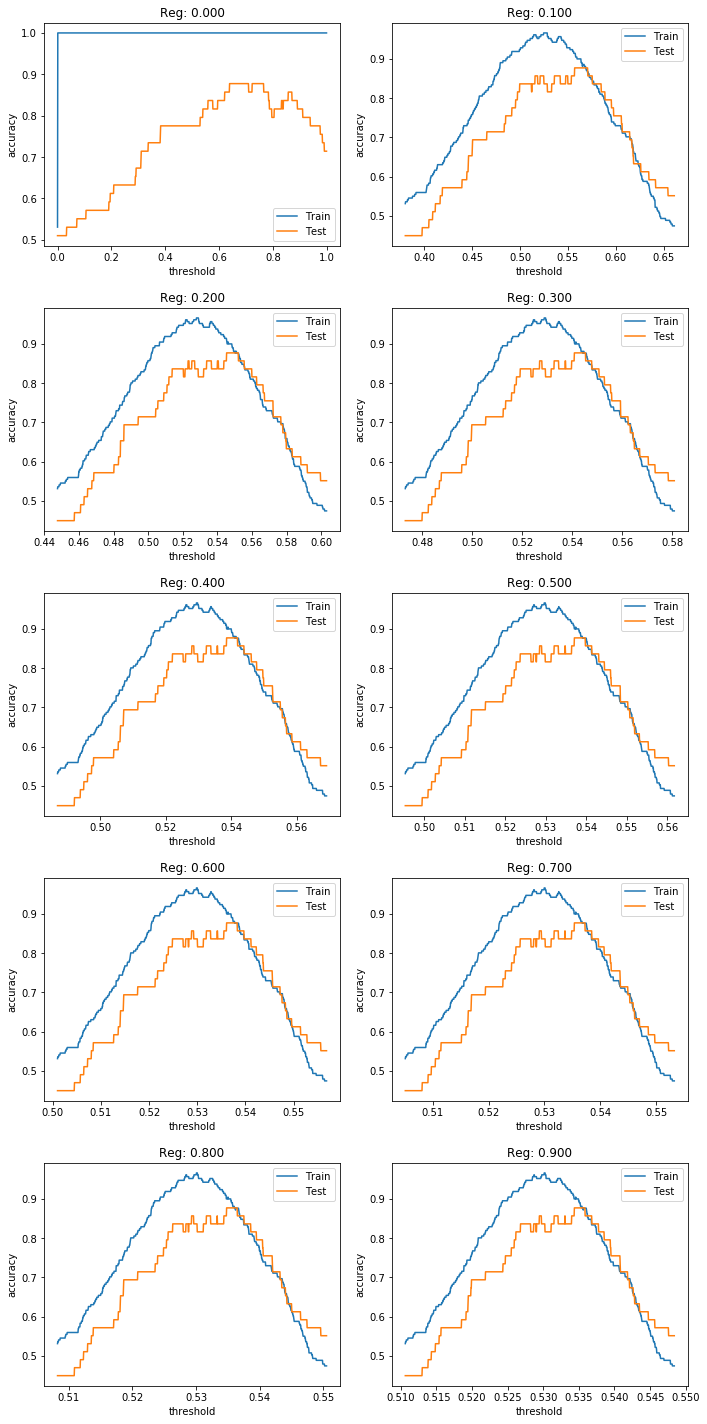

In [134]:
reg_lst = np.arange(0, 1, 0.1)
acc = []
row, col = 5, 2
fig,a =  plt.subplots(row,col)
fig.set_figheight(20)
fig.set_figwidth(10)
for index in range(len(reg_lst)):
    reg = reg_lst[index]
    model = RBF_classification(sigma=100, centre_selection = 'exact_interpolation',reg=reg)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    th, acc_train, acc_test = model.evaluate(y_pred_train, y_train, y_pred_test, y_test)
    
    i = int(index / col)
    j = int(index % col)
    a[i][j].plot(th, acc_train, label="Train")
    a[i][j].plot(th, acc_test, label="Test")
    a[i][j].set_xlabel('threshold')
    a[i][j].set_ylabel('accuracy')
    a[i][j].legend()
    a[i][j].title.set_text('Reg: {0:.3f}'.format(reg))
plt.tight_layout(pad=1.5)
plt.show()

### 2. b) Follow the strategy of “Fixed Centers Selected at Random” 

Fixed width: 100

In [19]:
model = RBF_classification(sigma=100, centre_selection = 'fixed_centers_selected_at_random', hidden_neurons=100)
model.fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
th, acc_train, acc_test = model.evaluate(y_pred_train, y_train, y_pred_test, y_test)

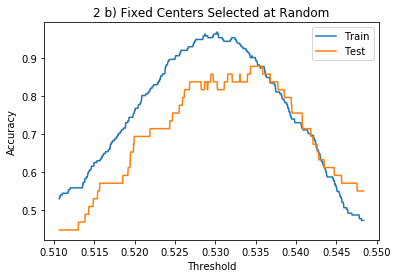

In [127]:
plt.plot(th, acc_train, label="Train")
plt.plot(th, acc_test, label="Test")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.title('2 b) Fixed Centers Selected at Random')
plt.show()

In [137]:
sigma1 = np.arange(0.1, 1, 0.5)
sigma2 = np.arange(1, 10, 5)
sigma3 = np.arange(10, 100, 50)
sigma4 = np.arange(100, 1000, 500)
sigma5 = np.arange(1000, 10000, 5000)
sigma_lst = np.concatenate([sigma1, sigma2, sigma3, sigma4, sigma5])

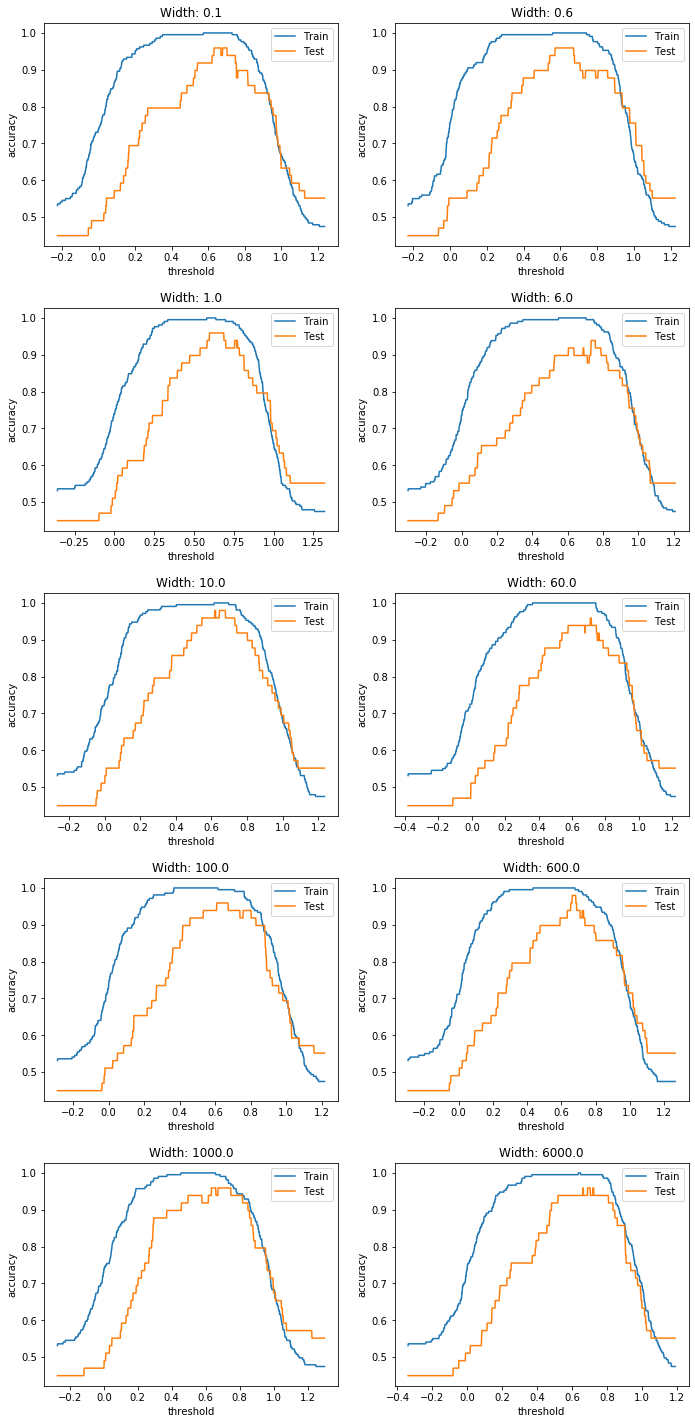

In [139]:
row, col = 5,2
fig,a =  plt.subplots(row,col)
fig.set_figheight(20)
fig.set_figwidth(10)

for index, sigma in enumerate(sigma_lst):
    model = RBF_classification(sigma=sigma, centre_selection = 'fixed_centers_selected_at_random', hidden_neurons=100)
    model.fit(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    th, acc_train, acc_test = model.evaluate(y_pred_train, y_train, y_pred_test, y_test)
    
    i = int(index / col)
    j = int(index % col)
    a[i][j].plot(th, acc_train, label="Train")
    a[i][j].plot(th, acc_test, label="Test")
    a[i][j].set_xlabel('threshold')
    a[i][j].set_ylabel('accuracy')
    a[i][j].legend()
    a[i][j].title.set_text('Width: {}'.format(sigma))
plt.tight_layout(pad=1.5)
plt.show()

### c) Try classical “K-Mean Clustering”

In [140]:
kmean = KMeans(n_clusters=2)
kmean.fit(X_train)
centers = kmean.cluster_centers_

In [150]:
model = RBF_classification(centre_selection = 'kmeans', n_clusters=2, hidden_neurons=100)
model.fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
th, acc_train, acc_test = model.evaluate(y_pred_train, y_train, y_pred_test, y_test)

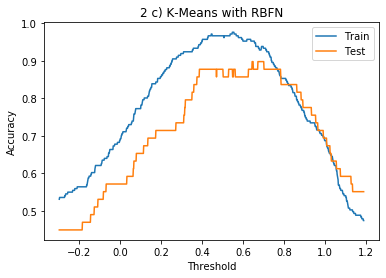

In [151]:
plt.plot(th, acc_train, label="Train")
plt.plot(th, acc_test, label="Test")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.title('2 c) K-Means with RBFN')
plt.show()

In [152]:
centres = model._select_centers(X_train)

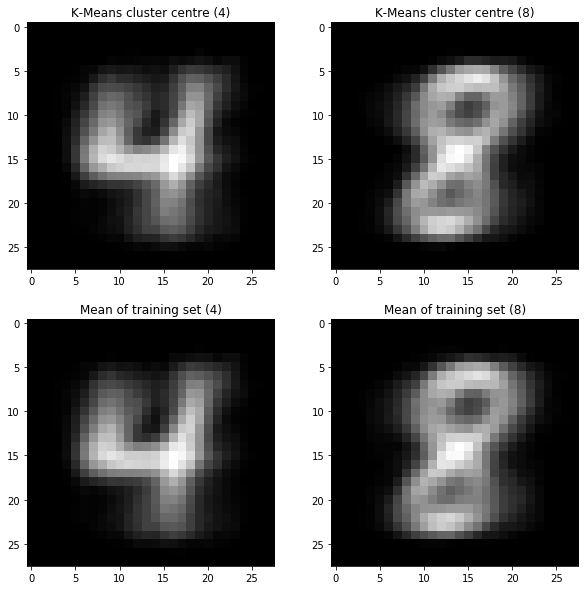

In [153]:
# Display cluster centres and mean of x_train
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].imshow(np.reshape(centres[0], (28,28)).transpose(), cmap='gray')
ax[0,0].set_title("K-Means cluster centre (4)")
ax[0,1].imshow(np.reshape(centres[1], (28,28)).transpose(), cmap='gray')
ax[0,1].set_title("K-Means cluster centre (8)")
ax[1,0].imshow(np.reshape(np.mean(X_train[y_train==1], axis=0), (28,28)).transpose(), cmap='gray')
ax[1,0].set_title("Mean of training set (4)")
ax[1,1].imshow(np.reshape(np.mean(X_train[y_train==0], axis=0), (28,28)).transpose(), cmap='gray')
ax[1,1].set_title("Mean of training set (8)")
plt.show()

## Q3. Self-Organizing Map (SOM) (20 Marks)

### a) 1D - heart curve

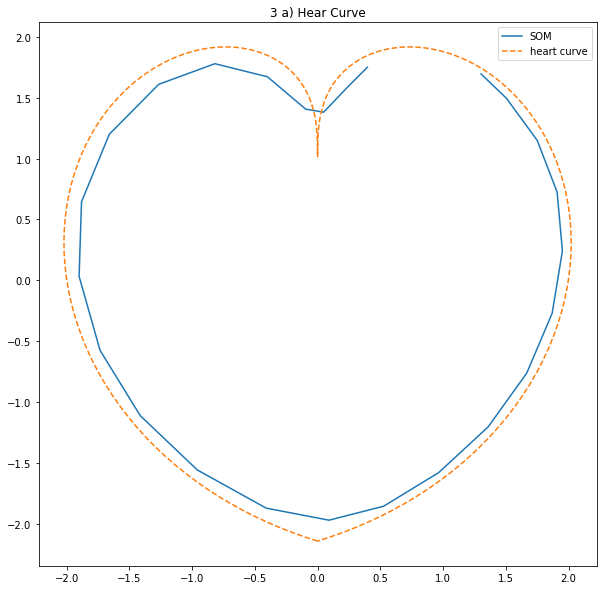

In [154]:
t = np.linspace(-np.pi, np.pi, 200)
X_train = np.array([t * np.sin(np.pi*np.sin(t)/t),1 - np.abs(t) * np.cos(np.pi*np.sin(t)/t)]).transpose()

som = np.random.rand(25,2)
iteration = 500
def get_sigma(n):
    sigma0 = np.sqrt(1**2 + 25**2)/2
    t1 = iteration/np.log(sigma0)
    return sigma0 * np.exp(-n/t1) 
def get_lr(n):
    lr0 = 0.1
    lr_min = 0.01
    return np.max([lr0*np.exp(-n/iteration), lr_min])

som = np.random.rand(25,2)
X_train = X_train.reshape(200,2)

for i in range(iteration):
    sigma = get_sigma(i)
    lr = get_lr(i)
    for j, x in enumerate(X_train):
        dist = np.sqrt(np.sum((som-x)**2, axis=-1))
        k = np.argmin(dist)
        for l in range(len(som)):
            d = l - k
            h = np.exp(-d**2/(2*sigma**2))
            som[l] = som[l] + lr*h*(x-som[l])

plt.figure(figsize=(10,10))
plt.plot(som[:,0], som[:,1], label="SOM")
plt.plot(X_train[:,0], X_train[:,1], linestyle="--",label="heart curve")
plt.title('3 a) Hear Curve')
plt.legend()
plt.show()

### b) 2D Square

In [155]:
class SOM_2D:
    def __init__(self, iteration=500, row=5, col=5):
        self.iteration = iteration
        self.row = row
        self.col = col
        self.sigma0 = np.sqrt(1**2 + 25**2)/2
        self.t1 = self.iteration/np.log(self.sigma0)
        self.lr0 = 0.1
        self.lr_min = 0.01
        
    def _get_sigma(self, n):
        return self.sigma0 * np.exp(-n/self.t1) 

    def _get_lr(self, n):
        return np.max([self.lr0*np.exp(-n/self.iteration), self.lr_min])
    
    def fit(self, X_train):
        input_dim = len(X_train[0])
        num = self.row * self.col
        som = np.random.rand(num, input_dim)
        for i in range(self.iteration):
            if i%100 == 0:
                print('Iteration: {}'.format(i))
            sigma = self._get_sigma(i)
            lr = self._get_lr(i)
            for j, x in enumerate(X_train):
                dist = np.sqrt(np.sum((som - x)**2, axis=-1))
                k = np.argmin(dist)
                k_row = int(k/self.col)
                k_col = k % self.col
                for l in range(len(som)):
                    row = int(l/self.col)
                    col = l%self.col
                    d = np.sqrt((row - k_row)**2 + (col - k_col)**2)
                    h = np.exp(-d**2/(2*sigma**2))
                    som[l] = som[l] + lr*h*(x-som[l])
        return som
    
    def get_som_labels(self, X_train, som):
        num = self.row * self.col
        labels = np.zeros((num,1))
        for i in range(num):
          dist = np.sqrt(np.sum((som[i]-X_train)**2, axis=-1))
          k = np.argmin(dist)
          labels[i] = y_train[k]
        return labels

In [156]:
t = np.linspace(-np.pi, np.pi, 200)
x_train = np.random.randn(500,2)
iteration = 500
row=5
col=5
som_2d = SOM_2D(iteration=500, row=5, col=5)
som = som_2d.fit(x_train)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400


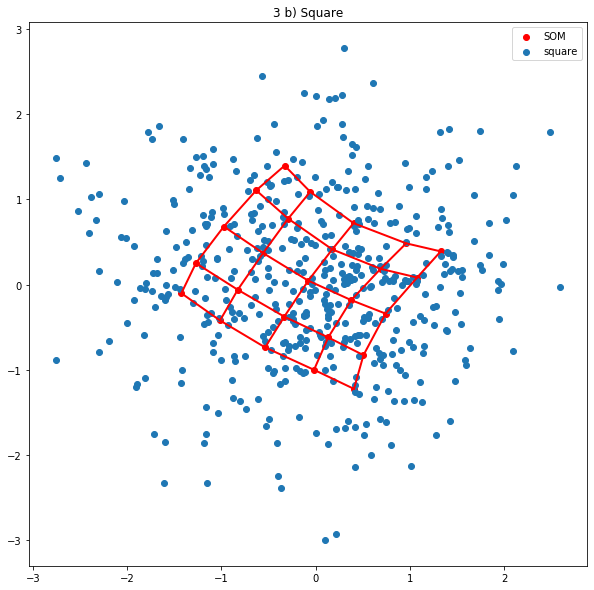

In [157]:
plt.figure(figsize=(10,10))
plt.scatter(som[:,0], som[:,1], color ="r", label="SOM")
# Plot grid line between points
num = row * col
for i in range(row,num+1,5):
  plt.plot(som[i-row:i,0], som[i-row:i,1], linewidth=2, color ="r")
for i in range(row):
  plt.plot(som[i:num:row,0], som[i:num:row,1], linewidth=2, color ="r")
plt.scatter(x_train[:,0], x_train[:,1], label="square")
plt.legend()
plt.title('3 b) Square')
plt.show()

### c) Use SOM to classify MNIST

In [48]:
data = loadmat("MNIST_database.mat")
index_train = np.squeeze((data["train_classlabel"] == 4) | (data["train_classlabel"] == 8))
index_test = np.squeeze((data["test_classlabel"] == 4) | (data["test_classlabel"] == 8))
X_train = data["train_data"][:,index_train].transpose()
y_train = np.squeeze(data["train_classlabel"][:,index_train])
y_train = (y_train == 4).astype(int) # convert to 1, 0
X_test = data["test_data"][:,index_test].transpose()
y_test = np.squeeze(data["test_classlabel"][:,index_test])
y_test = (y_test == 4).astype(int) # convert to 1,0

#### 3c-1

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400


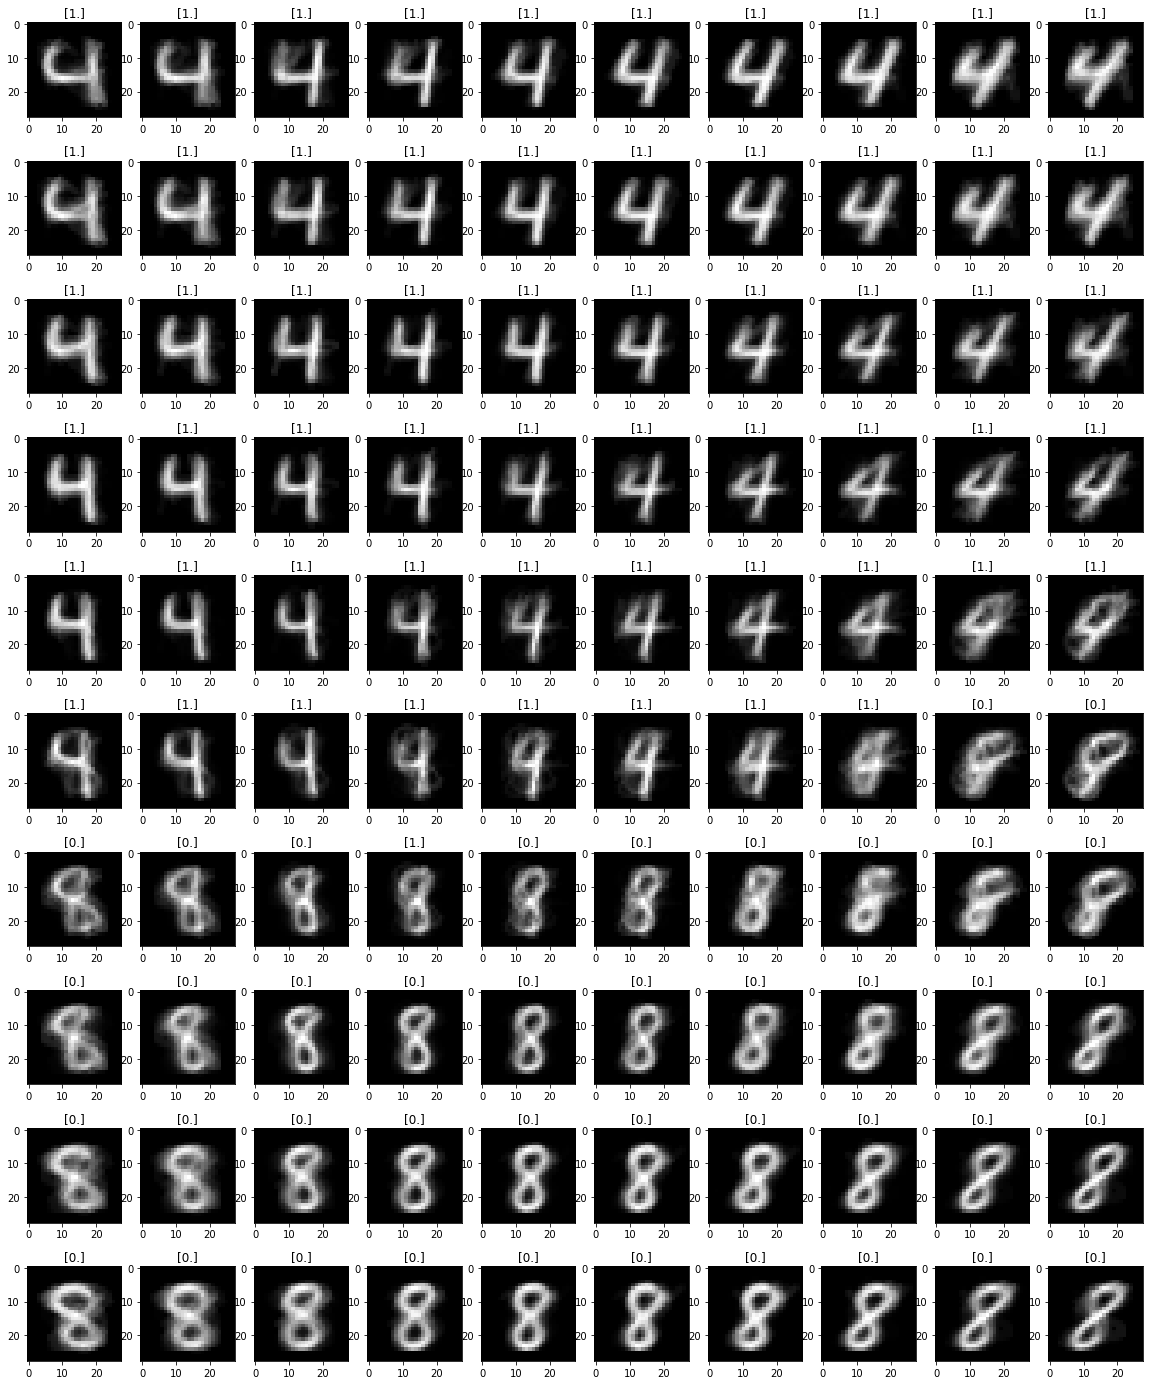

In [60]:
row, col = 10,10
num = col * row
t = np.linspace(-np.pi, np.pi, 200)
x_train = np.random.randn(500,2)
iteration = 500

som_2d = SOM_2D(iteration=iteration, row=row, col=col)
som = som_2d.fit(X_train)

labels = som_2d.get_som_labels(X_train, som)
fig, ax = plt.subplots(row, col, figsize=(20,25))
for i in range(len(w)):
  m = int(i/col)
  n = i%col
  ax[m,n].imshow(np.reshape(som[i], (28,28)).transpose(), cmap='gray')
  ax[m,n].set_title("{}".format(labels[i]))
plt.show()